In [1]:
import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GATConv
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [2]:

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the CSV file
df = pd.read_csv("/home/sandeep-sharma/Desktop/project2/jet_data.csv")

# Separate the signal and background events
signal_df = df[df['signal_or_background'] == 1]
background_df = df[df['signal_or_background'] == 0]


Using device: cuda


In [3]:

# Preprocess data function
def preprocess_data(df):
    """
    Preprocess the data by extracting features and labels,
    standardizing the node features, and creating the adjacency matrix.
    """
    node_features = df[['jet_pt', 'jet_eta', 'jet_phi', 'jet_mass']].values
    labels = df['signal_or_background'].values
    
    # Standardize the node features
    scaler = StandardScaler()
    node_features = scaler.fit_transform(node_features)

    # Create adjacency matrix (for simplicity, connect jets within the same event)
    num_jets = len(node_features)
    
    # Create adjacency matrix using KNN
    adj = create_adjacency_matrix(node_features, k=5)

    return node_features, adj, labels


In [4]:

def create_adjacency_matrix(node_features, k=5):
    """ Create adjacency matrix using k-nearest neighbors """
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(node_features)
    distances, indices = nbrs.kneighbors(node_features)
    adj = torch.zeros(len(node_features), len(node_features))
    for i in range(len(node_features)):
        adj[i, indices[i]] = 1
    return adj

# Prepare graph data
def prepare_graph_data(df):
    node_features, adj, labels = preprocess_data(df)

    # Convert to PyG Data format
    edge_index = torch.nonzero(adj).T  # Convert adjacency matrix to edge_index
    node_features = torch.tensor(node_features, dtype=torch.float)
    labels = torch.tensor(labels, dtype=torch.long)

    return Data(x=node_features, edge_index=edge_index, y=labels)


In [5]:

# Create a list of graphs (one per event)
graph_list = []
for i in range(0, len(df), 32):  # Use batch size of 32
    event_df = df.iloc[i:i+32]
    graph = prepare_graph_data(event_df)
    graph_list.append(graph)

# Create DataLoader for batching
loader = DataLoader(graph_list, batch_size=1, shuffle=True)


/home/sandeep-sharma/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:

# Define the GAT model
class GAT(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, 128, heads=8)
        self.gat2 = GATConv(128 * 8, 64, heads=8)
        self.gat3 = GATConv(64 * 8, out_channels)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.gat2(x, edge_index)
        return x


In [7]:

# Initialize the model, loss function, and optimizer
model = GAT(in_channels=4, out_channels=2).to(device)  # Move model to device (GPU/CPU)

# Compute class weights based on the class distribution (optional if dataset is perfectly balanced)
signal_count = len(signal_df)
background_count = len(background_df)
total_count = signal_count + background_count

weight_signal = total_count / (2 * signal_count)
weight_background = total_count / (2 * background_count)

class_weights = torch.tensor([weight_background, weight_signal], dtype=torch.float).to(device)  # Move class weights to device


In [9]:

# Set device (CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model, loss function, and optimizer
model = GAT(in_channels=4, out_channels=2).to(device) 
criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  
# Training loop
def train(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    data = data.to(device)  # Move data to device (GPU/CPU)
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for a number of epochs
epochs = 10
losses = []  # To track the loss curve
all_labels = []
all_logits = []  # Store logits instead of class predictions

for epoch in range(epochs):
    total_loss = 0
    
    for data_batch in loader:
        loss = train(model, data_batch, criterion, optimizer)
        total_loss += loss
        
        # Collect logits and labels for evaluation
        out = model(data_batch.to(device))  # Move batch data to device
        all_labels.append(data_batch.y.cpu().numpy())  # Move labels to CPU
        all_logits.append(out.cpu().detach().numpy())  # Store logits here
    
    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    scheduler.step(avg_loss)

    # Print loss for each epoch
    print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')

# Convert all_labels and all_logits to numpy arrays
all_labels = np.concatenate(all_labels)
all_logits = np.concatenate(all_logits)

# Apply softmax to logits to get probabilities
probs = F.softmax(torch.tensor(all_logits), dim=1)[:, 1].detach().cpu().numpy()  # Get probs for the positive class


Using device: cuda
Epoch 0, Average Loss: 1.1994
Epoch 1, Average Loss: 0.7059
Epoch 2, Average Loss: 0.7028
Epoch 3, Average Loss: 0.7008


KeyboardInterrupt: 

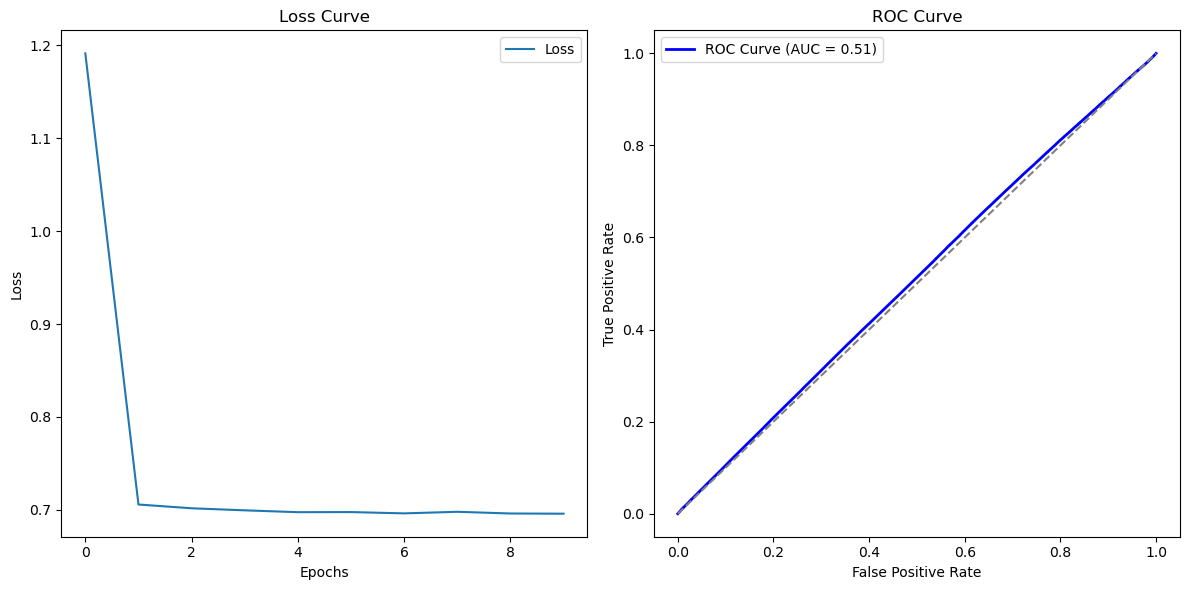

In [52]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(all_labels, probs)
roc_auc = auc(fpr, tpr)

# Plot Loss Curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()
